In [23]:
# ============================================================================
# CELDA 1: IMPORTACIÓN DE LIBRERÍAS Y CONFIGURACIÓN INICIAL
# ============================================================================
%run ./00_template.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from pathlib import Path

# Librerías de Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Configuración de gráficos
sns.set_style("whitegrid")
print("✅ Librerías cargadas y entorno configurado.")

=== 🌍 Template PEP1 Configurado Exitosamente ===
📂 Base Dir       : /home/jovyan
💾 GeoDatabase    : ✅ Encontrada
📊 Censo CSV      : ✅ Encontrado
✅ Librerías cargadas y entorno configurado.


In [24]:
# ============================================================================
# CELDA 2: CARGA, TRANSFORMACIÓN Y LIMPIEZA DE DATOS
# ============================================================================
# 1. Definir rutas
INPUT_CSV = OUTPUTS_DIR / "accesibilidad_otp_final.csv"
OUTPUT_PARQUET = OUTPUTS_DIR / "comunas_accesibilidad_wide.parquet"

print(f"📂 Leyendo archivo generado por OTP: {INPUT_CSV}")

if not INPUT_CSV.exists():
    raise FileNotFoundError("❌ No existe el CSV. Ejecuta el Notebook 03 primero.")

# 2. Cargar datos brutos
df_long = pd.read_csv(INPUT_CSV)

# 3. Pivotear (Transformar de formato Largo a Ancho)
# Fila = Comuna, Columnas = Categorías de servicio, Valor = Minutos
acc = df_long.pivot_table(
    index="cod", 
    columns="cat", 
    values="minutos", 
    aggfunc="min" 
).reset_index()

# Renombrar para estandarizar
acc = acc.rename(columns={"cod": "cod_comuna"})

# 4. Enriquecer con nombres de comunas (desde el GeoPackage)
gdf_base = gpd.read_file(RUTA_GPKG, layer="comunas_rm_censo")
mapping = gdf_base[["CUT_COM", "COMUNA"]].copy()
mapping["CUT_COM"] = mapping["CUT_COM"].astype(str)
acc["cod_comuna"] = acc["cod_comuna"].astype(str)

acc = acc.merge(mapping, left_on="cod_comuna", right_on="CUT_COM", how="left")
acc = acc.rename(columns={"NOM_COM": "comuna"})
acc = acc.drop(columns=["CUT_COM"])

# 5. Imputación de Valores Nulos
# Si un valor es NaN, significa que no hay ruta o está muy lejos.
# Lo reemplazamos con un valor alto (ej: 120 min) para "penalizar" esa comuna en el clustering.
numeric_cols = [c for c in acc.columns if c not in ["cod_comuna", "comuna"]]

for col in numeric_cols:
    nulls = acc[col].isna().sum()
    if nulls > 0:
        val_penalizacion = 120 # 2 horas
        print(f"⚠️ {col}: {nulls} comunas sin cobertura. Imputando {val_penalizacion} min.")
        acc[col] = acc[col].fillna(val_penalizacion)

# 6. Guardar dataset listo para ML
acc.to_parquet(OUTPUT_PARQUET, index=False)

print(f"\n✅ Datos procesados y guardados en: {OUTPUT_PARQUET}")
print("   Dimensiones:", acc.shape)
acc.head()

📂 Leyendo archivo generado por OTP: /home/jovyan/outputs/accesibilidad_otp_final.csv
⚠️ almacenes_barrio: 10 comunas sin cobertura. Imputando 120 min.
⚠️ areas_verdes: 6 comunas sin cobertura. Imputando 120 min.
⚠️ bancos: 12 comunas sin cobertura. Imputando 120 min.
⚠️ bencineras: 10 comunas sin cobertura. Imputando 120 min.
⚠️ bomberos: 10 comunas sin cobertura. Imputando 120 min.
⚠️ carabineros: 14 comunas sin cobertura. Imputando 120 min.
⚠️ deporte_infra: 2 comunas sin cobertura. Imputando 120 min.
⚠️ educacion_escolar: 4 comunas sin cobertura. Imputando 120 min.
⚠️ educacion_superior: 25 comunas sin cobertura. Imputando 120 min.
⚠️ estadios: 28 comunas sin cobertura. Imputando 120 min.
⚠️ ferias_libres: 12 comunas sin cobertura. Imputando 120 min.
⚠️ iglesias: 8 comunas sin cobertura. Imputando 120 min.
⚠️ malls: 24 comunas sin cobertura. Imputando 120 min.
⚠️ metro_tren: 40 comunas sin cobertura. Imputando 120 min.
⚠️ micro: 10 comunas sin cobertura. Imputando 120 min.
⚠️ munici

,cod_comuna,almacenes_barrio,areas_verdes,bancos,bencineras,bomberos,carabineros,deporte_infra,educacion_escolar,educacion_superior,...,ferias_libres,iglesias,malls,metro_tren,micro,municipios,museos,salud,supermercados,COMUNA
0,13101,2.733333,7.383333,8.466667,7.466667,10.433333,16.116667,3.633333,8.783333,1.600000,...,8.500000,5.583333,17.100000,120.0,0.816667,120.000000,1.583333,6.483333,3.483333,Santiago
1,13102,8.766667,3.566667,13.500000,7.233333,13.383333,30.316667,2.833333,3.800000,13.916667,...,7.666667,11.750000,120.000000,120.0,2.416667,26.933333,17.550000,7.333333,25.716667,Cerrillos
2,13103,5.716667,0.283333,15.500000,13.350000,11.483333,1.833333,1.200000,2.933333,120.000000,...,4.533333,13.066667,23.550000,120.0,0.333333,32.733333,120.000000,4.650000,10.866667,Cerro Navia
3,13104,10.650000,1.750000,23.266667,5.966667,15.616667,24.166667,1.783333,3.450000,120.000000,...,6.733333,4.200000,120.000000,120.0,3.066667,25.516667,120.000000,13.300000,15.200000,Conchalí
4,13105,8.883333,3.783333,8.500000,9.766667,15.166667,13.766667,3.783333,1.216667,120.000000,...,18.000000,4.250000,20.133333,120.0,5.483333,21.833333,120.000000,2.566667,19.600000,El Bosque


In [25]:
# ============================================================================
# CELDA 3: ESTADÍSTICAS DESCRIPTIVAS
# ============================================================================
print("📊 Resumen estadístico de tiempos de viaje (minutos):")
desc = acc[numeric_cols].describe().T
display(desc)

# Validaciones de seguridad
assert len(acc) >= 5, f"❌ Muy pocas comunas ({len(acc)}). Revisa el Notebook 03."
assert len(numeric_cols) >= 2, "❌ Necesitas al menos 2 categorías de servicios para hacer clustering."

📊 Resumen estadístico de tiempos de viaje (minutos):


,count,mean,std,min,25%,50%,75%,max
almacenes_barrio,43.0,35.055426,47.779979,0.650000,5.725000,9.033333,31.366667,120.0
areas_verdes,43.0,25.601938,40.842203,0.266667,3.441667,6.850000,19.575000,120.0
bancos,43.0,45.518605,48.429506,3.616667,9.616667,16.683333,120.000000,120.0
bencineras,43.0,37.076744,46.669229,2.433333,7.350000,11.316667,29.683333,120.0
bomberos,43.0,41.483333,44.199632,3.933333,14.366667,17.616667,37.125000,120.0
carabineros,43.0,51.097287,48.897334,1.833333,13.716667,24.166667,120.000000,120.0
deporte_infra,43.0,14.436434,26.163857,0.050000,2.641667,5.683333,10.550000,120.0
educacion_escolar,43.0,21.725969,35.447112,1.216667,3.508333,6.450000,19.550000,120.0
educacion_superior,43.0,78.760465,50.772619,1.600000,21.116667,120.000000,120.000000,120.0
estadios,43.0,86.308915,46.886227,9.433333,27.358333,120.000000,120.000000,120.0


✅ Columnas seleccionadas para el análisis (Features):
['almacenes_barrio', 'areas_verdes', 'bancos', 'bencineras', 'bomberos', 'carabineros', 'deporte_infra', 'educacion_escolar', 'educacion_superior', 'estadios', 'ferias_libres', 'iglesias', 'malls', 'metro_tren', 'micro', 'municipios', 'museos', 'salud', 'supermercados']

📈 Varianza explicada: 63.20%


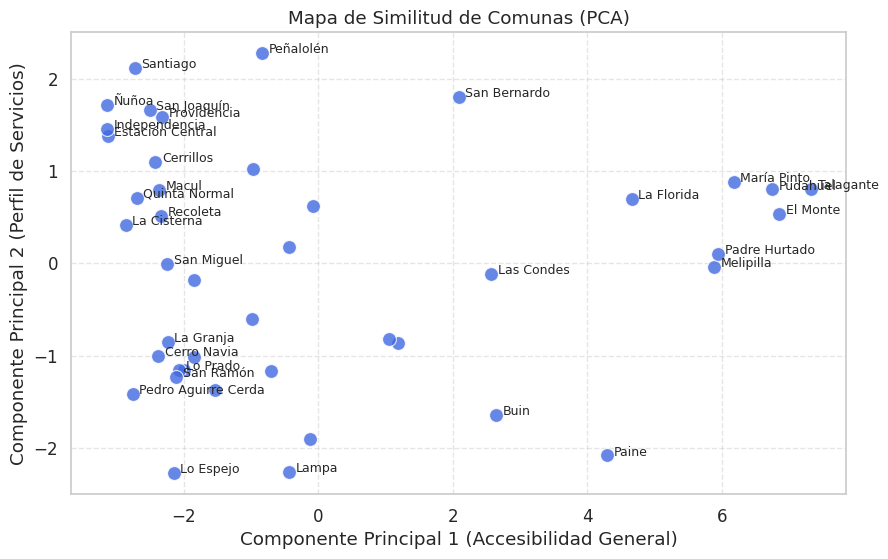

In [26]:
# ============================================================================
# CELDA 4: PREPROCESAMIENTO Y PCA (CORREGIDA)
# ============================================================================
# 1. FILTRADO INTELIGENTE DE COLUMNAS
# Pandas tiene una función para seleccionar solo números automáticamente.
# Esto evita que se cuelen columnas de texto como "Santiago".
X = acc.select_dtypes(include=['number']).copy()

# Por seguridad, eliminamos 'cod_comuna' si es que quedó como número por error
if "cod_comuna" in X.columns:
    X = X.drop(columns=["cod_comuna"])

# Verificar qué columnas vamos a usar
print("✅ Columnas seleccionadas para el análisis (Features):")
print(X.columns.tolist())

# Asegurarnos de que no esté vacío
if X.empty or len(X.columns) < 2:
    raise ValueError("❌ Error: No se encontraron columnas numéricas suficientes.")

# 2. Estandarizar (StandardScaler)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. PCA para visualizar en 2D
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"\n📈 Varianza explicada: {pca.explained_variance_ratio_.sum():.2%}")

# 4. Graficar
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], alpha=0.8, s=100, color='royalblue')

# Etiquetar algunas comunas para referencia
# Usamos acc["comuna"] (o la columna de nombre que tengas) para las etiquetas
nombres_comunas = acc["comuna"] if "comuna" in acc.columns else acc["COMUNA"]

for i, txt in enumerate(nombres_comunas):
    # Solo etiquetamos si están lejos del centro (outliers visuales) para no llenar el mapa
    if abs(X_pca[i,0]) > 2 or abs(X_pca[i,1]) > 2:
        plt.annotate(txt, (X_pca[i,0]+0.1, X_pca[i,1]), fontsize=9)

plt.title("Mapa de Similitud de Comunas (PCA)")
plt.xlabel("Componente Principal 1 (Accesibilidad General)")
plt.ylabel("Componente Principal 2 (Perfil de Servicios)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

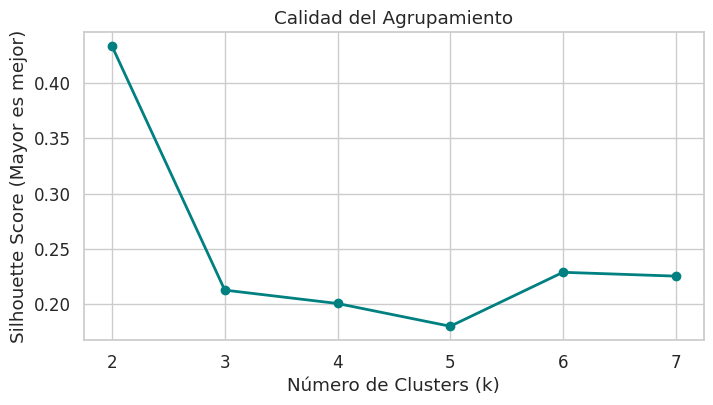

In [27]:
# ============================================================================
# CELDA 5: DETERMINACIÓN DEL NÚMERO ÓPTIMO DE CLUSTERS (K)
# ============================================================================
scores = []
K_range = range(2, 8) # Probaremos dividir Santiago en 2 a 7 zonas

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    scores.append(score)

plt.figure(figsize=(8, 4))
plt.plot(K_range, scores, marker="o", linestyle="-", color="teal", linewidth=2)
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Silhouette Score (Mayor es mejor)")
plt.title("Calidad del Agrupamiento")
plt.xticks(K_range)
plt.grid(True)
plt.show()

In [28]:
# ============================================================================
# CELDA 6: APLICACIÓN DEL MODELO FINAL (K-MEANS)
# ============================================================================
# --- AJUSTA ESTE VALOR SEGÚN EL GRÁFICO ANTERIOR ---
K_OPTIMO = 4
# ---------------------------------------------------

kmeans = KMeans(n_clusters=K_OPTIMO, random_state=42, n_init=10)
acc["cluster"] = kmeans.fit_predict(X_scaled)

print(f"✅ Clustering completado con K={K_OPTIMO}")
print("\nDistribución de comunas por cluster:")
print(acc["cluster"].value_counts().sort_index())

# Mostrar ejemplos por cluster
for k in range(K_OPTIMO):
    print(f"\n📁 Cluster {k}:", acc[acc["cluster"]==k]["COMUNA"].head(5).tolist(), "...")

✅ Clustering completado con K=4

Distribución de comunas por cluster:
cluster
0     8
1    16
2    12
3     7
Name: count, dtype: int64

📁 Cluster 0: ['La Florida', 'Pudahuel', 'Paine', 'Melipilla', 'María Pinto'] ...

📁 Cluster 1: ['Cerro Navia', 'Conchalí', 'El Bosque', 'La Granja', 'La Pintana'] ...

📁 Cluster 2: ['Santiago', 'Cerrillos', 'Estación Central', 'Independencia', 'La Cisterna'] ...

📁 Cluster 3: ['Huechuraba', 'Las Condes', 'Maipú', 'Puente Alto', 'San Bernardo'] ...


In [29]:
# ============================================================================
# CELDA 7: INTERPRETACIÓN DE LOS PERFILES (CORREGIDA)
# ============================================================================
# 1. Identificar dinámicamente las columnas numéricas de servicios
# Buscamos solo columnas numéricas
cols_analisis = acc.select_dtypes(include=['number']).columns.tolist()

# Limpiamos la lista: No queremos promediar el 'cluster' ni códigos
columnas_a_excluir = ["cluster", "cod_comuna", "cod", "CUT_COM"]
cols_analisis = [c for c in cols_analisis if c not in columnas_a_excluir]

print(f"📊 Generando perfil basado en {len(cols_analisis)} servicios:")
print(cols_analisis)

# 2. Calcular el tiempo promedio por cluster
# Agrupamos por cluster y solo pedimos el promedio de las columnas filtradas
perfil = acc.groupby("cluster")[cols_analisis].mean()

print("\n⏱️ Tiempos promedio de viaje (minutos) por cluster:")
print("(Verde 🟩 = Menor tiempo = Mejor accesibilidad)")
print("(Rojo 🟥 = Mayor tiempo = Peor accesibilidad)")

# 3. Mostrar tabla con colores
# Usamos 'RdYlGn_r' invertido: Verde para valores bajos (bueno), Rojo para altos (malo)
display(perfil.style.background_gradient(cmap="RdYlGn_r"))

📊 Generando perfil basado en 19 servicios:
['almacenes_barrio', 'areas_verdes', 'bancos', 'bencineras', 'bomberos', 'carabineros', 'deporte_infra', 'educacion_escolar', 'educacion_superior', 'estadios', 'ferias_libres', 'iglesias', 'malls', 'metro_tren', 'micro', 'municipios', 'museos', 'salud', 'supermercados']

⏱️ Tiempos promedio de viaje (minutos) por cluster:
(Verde 🟩 = Menor tiempo = Mejor accesibilidad)
(Rojo 🟥 = Mayor tiempo = Peor accesibilidad)


,almacenes_barrio,areas_verdes,bancos,bencineras,bomberos,carabineros,deporte_infra,educacion_escolar,educacion_superior,estadios,ferias_libres,iglesias,malls,metro_tren,micro,municipios,museos,salud,supermercados
cluster,,,,,,,,,,,,,,,,,,,
0,120.000000,90.570833,114.295833,120.000000,107.277083,107.250000,47.768750,81.960417,116.197917,120.000000,120.000000,114.695833,120.000000,112.006250,107.235417,120.000000,120.000000,94.997917,101.687500
1,15.353125,6.045833,14.164583,11.943750,25.331250,28.939583,3.758333,6.062500,90.058333,77.496875,19.019792,8.001042,57.053125,106.597917,18.284375,32.269792,120.000000,9.065625,21.042708
2,5.216667,4.726389,11.827778,7.572222,21.373611,25.679167,3.800000,4.451389,24.069444,55.944444,20.404167,7.976389,52.323611,120.000000,1.698611,34.015278,18.711111,9.658333,10.033333
3,34.161905,31.838095,96.338095,50.333333,37.683333,81.142857,18.983333,18.302381,103.907143,120.000000,48.778571,39.402381,109.880952,120.000000,42.988095,106.804762,107.171429,23.290476,63.911905


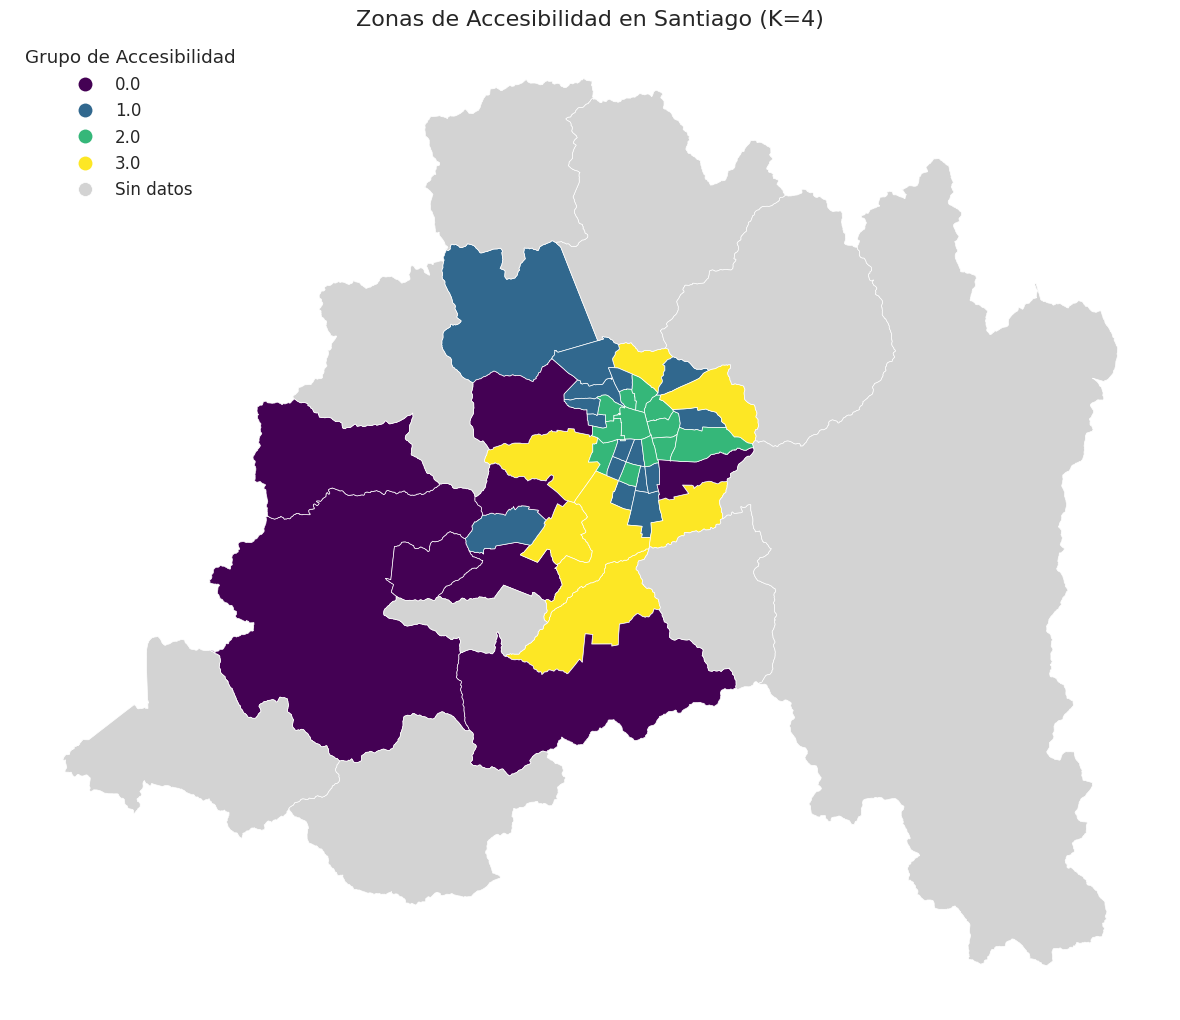

In [30]:
# ============================================================================
# CELDA 8: VISUALIZACIÓN ESPACIAL (MAPA)
# ============================================================================
# 1. Cargar geometrías
gdf_map = gpd.read_file(RUTA_GPKG, layer="comunas_rm_censo")
gdf_map["CUT_COM"] = gdf_map["CUT_COM"].astype(str)

# 2. Unir resultados del clustering
gdf_final = gdf_map.merge(acc[["cod_comuna", "cluster"]], left_on="CUT_COM", right_on="cod_comuna", how="left")

# 3. Plotear
fig, ax = plt.subplots(figsize=(12, 12))

gdf_final.plot(
    column="cluster",
    cmap="viridis",        # Paleta de colores
    categorical=True,      # Tratar clusters como categorías, no números continuos
    legend=True,
    legend_kwds={'title': 'Grupo de Accesibilidad', 'loc': 'upper left'},
    missing_kwds={'color': 'lightgrey', 'label': 'Sin datos'},
    edgecolor="white",
    linewidth=0.5,
    ax=ax
)

ax.set_title(f"Zonas de Accesibilidad en Santiago (K={K_OPTIMO})", fontsize=16)
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [31]:
# ============================================================================
# CELDA 9: GUARDADO FINAL Y EXPORTACIÓN
# ============================================================================
# 1. Asignamos nombres legibles a los clusters (OPCIONAL, PERO RECOMENDADO)
# Ajusta estos nombres según lo que viste en tu mapa K=4 y la tabla de promedios.
# Ejemplo basado en tu imagen (verifica con tus datos reales cuál es cuál):
# Si Cluster 0 es lento (Maipú), Cluster 1 es medio (Centro), etc.

# Para saber cuál es cuál, miramos los promedios de nuevo:
print("Promedios para identificar etiquetas:")
display(acc.groupby("cluster")[cols_analisis].mean().mean(axis=1))

# Supongamos (¡Revisa los números!) que:
# 0 = Periferia Poniente
# 1 = Periferia Norte
# 2 = Cono Oriente (Tiempos más bajos)
# 3 = Eje Centro-Sur
# dic_etiquetas = {0: "Poniente", 1: "Norte", 2: "Oriente (Alta Acceso)", 3: "Centro-Sur"}
# acc["nombre_cluster"] = acc["cluster"].map(dic_etiquetas)

# 2. Guardar CSV Final
OUTPUT_FINAL = OUTPUTS_DIR / "comunas_accesibilidad_clusters.csv"
acc.to_csv(OUTPUT_FINAL, index=False)

print(f"💾 Archivo final guardado en: {OUTPUT_FINAL}")
print("¡Felicidades! Has completado el análisis de accesibilidad.")

Promedios para identificar etiquetas:


cluster
0    107.154934
1     35.288871
2     23.130629
3     66.048371
dtype: float64

💾 Archivo final guardado en: /home/jovyan/outputs/comunas_accesibilidad_clusters.csv
¡Felicidades! Has completado el análisis de accesibilidad.


TOP 3 MEJORES LUGARES PARA VIVIR:
   ✅ Independencia: Índice 0.0
   ✅ Ñuñoa: Índice 0.2
   ✅ Estación Central: Índice 0.3

TOP 3 PEORES LUGARES (MENOS ACCESIBLES):
   ❌ Talagante: Índice 100.0
   ❌ El Monte: Índice 97.5
   ❌ Pudahuel: Índice 95.4


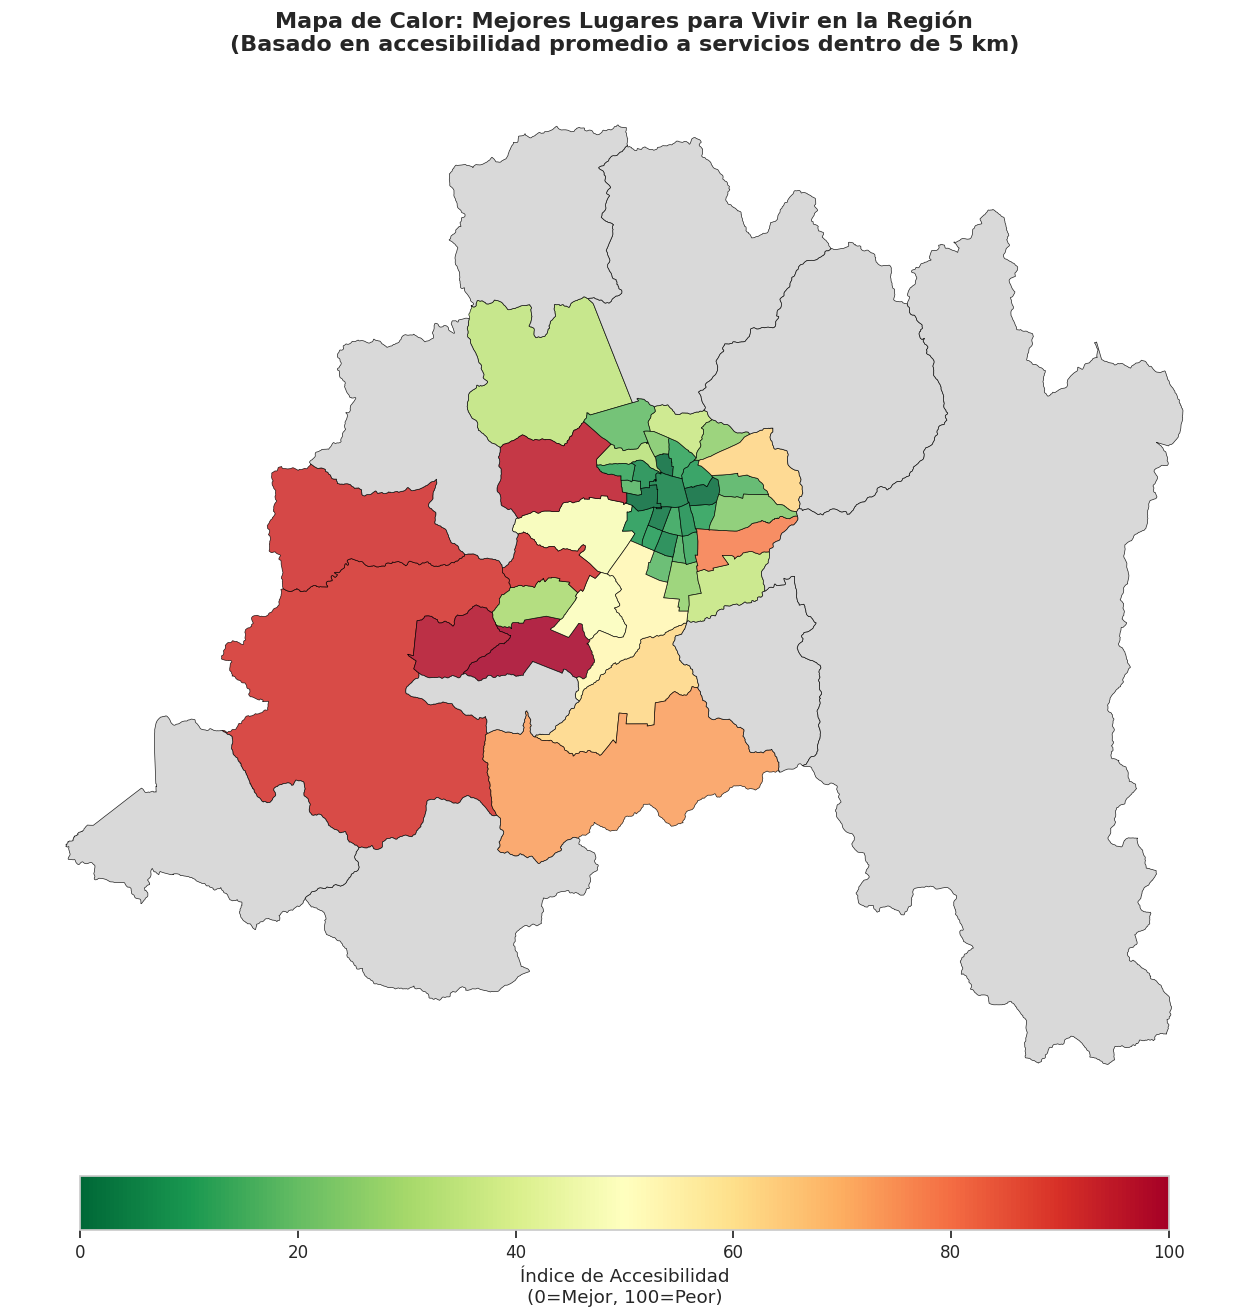


📊 RANKING COMPLETO DE COMUNAS (Mejores primero):


,cod_comuna,COMUNA,cluster,indice_accesibilidad
7,13108,Independencia,2,0.000000
18,13120,Ñuñoa,2,0.235669
5,13106,Estación Central,2,0.254523
19,13121,Pedro Aguirre Cerda,1,1.985620
0,13101,Santiago,2,4.412584
8,13109,La Cisterna,2,5.189864
24,13126,Quinta Normal,2,6.912391
27,13129,San Joaquín,2,7.413724
1,13102,Cerrillos,2,9.407913
21,13123,Providencia,2,9.448191



💾 Ranking guardado en: /home/jovyan/outputs/ranking_mejores_lugares_para_vivir.csv


In [33]:

# ============================================================================
# CELDA 10: MAPA DE CALOR - MEJORES LUGARES PARA VIVIR
# ============================================================================
# Esta celda visualiza la accesibilidad general como un mapa de calor espacial.
# Verde/Azul = Buena accesibilidad (mejores lugares)
# Rojo/Naranja = Pobre accesibilidad (peores lugares)

# 1. Calcular Índice de Accesibilidad (promedio de tiempos normalizados)
# Esto simula un "punto de referencia" donde una persona promedio quiere estar
# con acceso rápido a todos los servicios
accesibilidad_index = acc[cols_analisis].mean(axis=1)  # Promedio de tiempos de viaje

# Normalizar entre 0 y 100 (0 = mejor, 100 = peor)
acc["indice_accesibilidad"] = (
    (accesibilidad_index - accesibilidad_index.min()) / 
    (accesibilidad_index.max() - accesibilidad_index.min()) * 100
)

# 2. Unir con geometrías
gdf_heatmap = gdf_map.merge(
    acc[["cod_comuna", "indice_accesibilidad"]], 
    left_on="CUT_COM", 
    right_on="cod_comuna", 
    how="left"
)

# 3. Crear el mapa de calor
fig, ax = plt.subplots(figsize=(14, 14))

# Plotear con colores invertidos: Verde (bajo = bueno), Rojo (alto = malo)
gdf_heatmap.plot(
    column="indice_accesibilidad",
    ax=ax,
    legend=True,
    cmap="RdYlGn_r",  # Red-Yellow-Green invertido
    legend_kwds={
        'label': "Índice de Accesibilidad\n(0=Mejor, 100=Peor)",
        'orientation': "horizontal",
        'pad': 0.05,
        'shrink': 0.8
    },
    missing_kwds={'color': 'lightgrey', 'label': 'Sin datos'},
    edgecolor="black",
    linewidth=0.5,
    alpha=0.85
)

ax.set_title(
    "Mapa de Calor: Mejores Lugares para Vivir en la Región\n"
    "(Basado en accesibilidad promedio a servicios dentro de 5 km)",
    fontsize=16,
    fontweight='bold',
    pad=20
)
ax.set_axis_off()

# Añadir etiquetas a los mejores y peores lugares
top_best = acc.nsmallest(3, "indice_accesibilidad")[["cod_comuna", "COMUNA", "indice_accesibilidad"]]
top_worst = acc.nlargest(3, "indice_accesibilidad")[["cod_comuna", "COMUNA", "indice_accesibilidad"]]

print("TOP 3 MEJORES LUGARES PARA VIVIR:")
for _, row in top_best.iterrows():
    print(f"   ✅ {row['COMUNA']}: Índice {row['indice_accesibilidad']:.1f}")

print("\nTOP 3 PEORES LUGARES (MENOS ACCESIBLES):")
for _, row in top_worst.iterrows():
    print(f"   ❌ {row['COMUNA']}: Índice {row['indice_accesibilidad']:.1f}")

plt.tight_layout()
plt.show()

# 4. Tabla de ranking
ranking = acc[["cod_comuna", "COMUNA", "cluster", "indice_accesibilidad"]].copy()
ranking = ranking.sort_values("indice_accesibilidad")

print("\n📊 RANKING COMPLETO DE COMUNAS (Mejores primero):")
display(ranking.head(15))

# 5. Guardar tabla de ranking
ranking.to_csv(OUTPUTS_DIR / "ranking_mejores_lugares_para_vivir.csv", index=False)
print(f"\n💾 Ranking guardado en: {OUTPUTS_DIR}/ranking_mejores_lugares_para_vivir.csv")
